In [1]:
#Для общего топа интересна классификация на основе часовых поясов. 
#Постараться выделить часы наибольшей активности игроков в городах данного пояса.
import pandas as pd
import seaborn
import geopy
from datetime import datetime
import time
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import numpy as np
import matplotlib.pyplot as plt
import pytz
from pytz import country_timezones

%matplotlib inline

timezone_country = {}
for countrycode in country_timezones:
    timezones = country_timezones[countrycode]
    for timezone in timezones:
        timezone_country[timezone] = countrycode


def hour(timestamp):
    now  = datetime.fromtimestamp(timestamp)
    return now.hour

def hour_utc(timestamp):
    now  = datetime.utcfromtimestamp(timestamp)
    return now.hour

def get_timezone(city):
    place,(lat,lon) = do_geocode(city)
    timezone = do_timezone((lat,lon))
    return timezone

def do_geocode(address):
    g = geopy.GoogleV3()
    try:
        return g.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)

def do_timezone((lat,lon)):
    g = geopy.GoogleV3()
    try:
        return g.timezone((lat,lon))
    except GeocoderTimedOut:
        return do_timezone((lat,lon))    
    
print "imported!"

imported!


1603           Leipzig
1604           Jakarta
1605    Rio De Janeiro
1606        Manchester
1607         Bucharest
1608        Birmingham
1609            Athens
1610          Montréal
1611        Montevideo
1612      Buenos Aires
1613          Belgrade
1614         São Paulo
1615             Paris
1616           Bangkok
1617          Istanbul
1618            Warsaw
1619           Hamburg
1620            London
1621             Hanoi
1622            Berlin
Name: city, dtype: object
City list was created. The length of city list:  1623


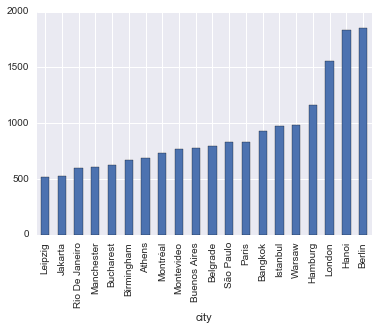

In [2]:
#найдем города по количеству игроков
pinfo_ww = pd.read_csv("pinfo_ww.csv", sep="|")
table_count_players = pinfo_ww.groupby('city').size()
table_count_players.sort_values(inplace=True)
table_count_players.tail(20)
table_count_players.sort_values().tail(20).plot(kind='bar')
table_count_players = table_count_players[table_count_players > 25]
df_table_count_players = pd.DataFrame(table_count_players)
df_table_count_players = df_table_count_players.reset_index(level='city')
city_list = df_table_count_players.city
print city_list.tail(20) #города ко-во пользователей которых составляет >25
print "City list was created. The length of city list: ",len(df_table_count_players)

In [3]:
pact_ww = pd.read_csv("pact+pinfo.csv", sep="|")
print pact_ww.columns

print "Read!"

Index([u'Unnamed: 0', u'id', u'actdate', u'actdate_num', u'actflag',
       u'payflag', u'pgrflag', u'ml_num', u'transactions', u'quests_end',
       u'm_quests_end', u'days_from_last_actdate', u'days_from_last_payment',
       u'utc_timestamp', u'gender', u'birthyear', u'country', u'region',
       u'city', u'traffic', u'traftype'],
      dtype='object')
Read!


In [4]:
group = pact_ww.groupby(['city','utc_timestamp','actflag','actdate','region','country'], as_index=True).size()

In [5]:
#print grope.head(40)
group = group.reset_index(level=['city','utc_timestamp','actflag','actdate','region','country'])

In [6]:
group = group[group.actflag != False]


In [7]:
group["hour"] = "" #добавляем параметр hour

In [8]:
hour_utc_list = []
for stamp in group.utc_timestamp:
    hour_utc_list.append(hour_utc(stamp))

In [9]:
group["hour"] = hour_utc_list

In [10]:
print group.head(3)
print "len: ",len(group.hour)

             city  utc_timestamp actflag     actdate region country  0  hour
10   's-graveland     1452694444    True  2016-01-13     07      NL  1    14
11   's-graveland     1452694444    True  2016-01-14     07      NL  1    14
12  's-gravenhage     1453645320    True  2016-01-24     11      NL  1    14
len:  753039


In [11]:
pinfo_ww = pd.read_csv("pinfo_ww.csv", sep="|")
geolocator = Nominatim()
TZ_list = []

In [12]:
try:
    TZ = pd.read_csv("time_zone.csv")
    TZ_list = TZ.time_zone
except:
#ПАРСИНГ ЧАСОВОГО ПОЯСА ГОРОДОВ (city_list)
#ЗАПУСКАТЬ ЕСЛИ НЕ СФОРМИРОВАН TZ_list !!!!!!!!!!!!
    i = 1
    for city in city_list:
        tmp = get_timezone(city)
        TZ_list.append(tmp)
        print tmp# ," :::  ", i
        #i+=1


In [13]:
print len(TZ_list)

1623


In [14]:
utc_list = []
for tz in TZ_list:
    today = datetime.now()
    pst = pytz.timezone(tz)
    utc_list.append(pst.utcoffset(today).total_seconds()/60/60) 

In [15]:
print len(utc_list)

1623


In [16]:
data = {
    'city':city_list,
    #'country':country_list,
    'time_zone':TZ_list,
    'utc':utc_list
}
df_city_time_zone = pd.DataFrame(data)

In [17]:
df_result = pd.merge(group, df_city_time_zone, how='inner', on='city')
print group.columns
print df_city_time_zone.columns
#print df_result.groupby(['city','country']).size().head(10)

Index([         u'city', u'utc_timestamp',       u'actflag',       u'actdate',
              u'region',       u'country',                0,          u'hour'],
      dtype='object')
Index([u'city', u'time_zone', u'utc'], dtype='object')


In [18]:
city_for_del = df_result
print city_for_del
#Так как в разных странах есть города с одинаковыми названиями, удалим их из структуры данных, причем оставим те дубликаты из которых
#исходит наибольший трафик (оставляем максимальные перед этим отсортировав от меньшнго к большему), и тем самым оставим 
#крупные города
city_for_del = city_for_del.drop_duplicates(subset='city', keep='last')
print city_for_del.tail(10)
df_result = city_for_del

           city  utc_timestamp actflag     actdate region country  0  hour  \
0       Aabybro     1452039520    True  2016-01-06     19      DK  1     0   
1       Aabybro     1452039520    True  2016-03-28     19      DK  1     0   
2       Aabybro     1452269536    True  2016-01-08     19      DK  1    16   
3       Aabybro     1452350815    True  2016-01-09     19      DK  1    14   
4       Aabybro     1452594236    True  2016-01-12     19      DK  1    10   
5       Aabybro     1452594236    True  2016-01-13     19      DK  1    10   
6       Aabybro     1452612225    True  2016-01-12     19      DK  1    15   
7       Aabybro     1452612225    True  2016-01-13     19      DK  1    15   
8       Aabybro     1452612225    True  2016-01-14     19      DK  1    15   
9       Aabybro     1452612225    True  2016-01-16     19      DK  1    15   
10      Aabybro     1452612225    True  2016-01-17     19      DK  1    15   
11      Aabybro     1452612225    True  2016-01-21     19      D

In [19]:
list_utc = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 5.5, 7.0, 8.0, 9.0, 10.0, 12.0, 6.0, -10.0, -8.0, -7.0, -6.0, -5.0, -4.0, -3.0, 9.5]

In [20]:
#максимльное количество игроков в каждом часовом поясе (country)
#Формируем DataFrame по часовым поясам, country, часам  - gr 
#Выявляем знаковые country часовых зон -  gr_utc_country
gr2 = df_result.groupby(['utc','hour']).size()
gr2 = gr2.rename("maximum_users")
gr2 = gr2.reset_index(['utc','hour'])
gr = df_result.groupby(['utc','country','hour']).size()
#print gr
gr = gr.rename("maximum_users")
gr = gr.reset_index(['utc','country','hour'])



gr_utc_country = gr.groupby(['utc','country']).size()
gr_utc_country = gr_utc_country.rename("del")
gr_utc_country = gr_utc_country.reset_index(['utc','country'])

#Так как в разных странах есть города с одинаковыми названиями, удалим их из выборки
gr_utc_country
#if (len(list(gr_utc_country.country[gr_utc_country.utc == utc]))<2):

for utc in list_utc:
    gr_utc_country.country[gr_utc_country.utc == utc] = str(list(gr_utc_country.country[gr_utc_country.utc == utc]))

gr_utc_country = gr_utc_country.drop('del', axis=1)
gr_utc_country = gr_utc_country.drop_duplicates()
gr_utc_country

C:\Users\Maxim\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,utc,country
0,-10.0,"['PF', 'US']"
2,-8.0,"['GB', 'US']"
4,-7.0,"['CA', 'CR', 'FR', 'GB', 'MX', 'PH', 'US']"
11,-6.0,"['AR', 'BR', 'CA', 'NI', 'SV', 'US']"
17,-5.0,"['AU', 'CA', 'CO', 'EC', 'GB', 'GY', 'MX', 'PE..."
28,-4.0,"['AU', 'BR', 'BS', 'CA', 'CL', 'DO', 'EG', 'FR..."
45,-3.0,"['AR', 'BR', 'CA', 'UY']"
49,0.0,"['CI', 'IS', 'PT']"
52,1.0,"['AU', 'CA', 'DZ', 'GB', 'MA', 'PT', 'US']"
59,2.0,"['AL', 'AT', 'BA', 'BE', 'CH', 'CW', 'CZ', 'DE..."


In [21]:
gr = pd.merge(gr2,gr_utc_country, how = 'inner', on ='utc')
gr

,utc,hour,maximum_users,country
0,-10.0,4,1,"['PF', 'US']"
1,-10.0,20,1,"['PF', 'US']"
2,-8.0,21,1,"['GB', 'US']"
3,-8.0,22,1,"['GB', 'US']"
4,-7.0,0,6,"['CA', 'CR', 'FR', 'GB', 'MX', 'PH', 'US']"
5,-7.0,1,8,"['CA', 'CR', 'FR', 'GB', 'MX', 'PH', 'US']"
6,-7.0,2,5,"['CA', 'CR', 'FR', 'GB', 'MX', 'PH', 'US']"
7,-7.0,3,4,"['CA', 'CR', 'FR', 'GB', 'MX', 'PH', 'US']"
8,-7.0,4,5,"['CA', 'CR', 'FR', 'GB', 'MX', 'PH', 'US']"
9,-7.0,5,5,"['CA', 'CR', 'FR', 'GB', 'MX', 'PH', 'US']"


In [22]:
table = gr.pivot_table(index="hour", columns=['utc','country'], values="maximum_users")
table

utc,-10.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,0.0,1.0,2.0,...,4.0,5.0,5.5,6.0,7.0,8.0,9.0,9.5,10.0,12.0
country,"['PF', 'US']","['GB', 'US']","['CA', 'CR', 'FR', 'GB', 'MX', 'PH', 'US']","['AR', 'BR', 'CA', 'NI', 'SV', 'US']","['AU', 'CA', 'CO', 'EC', 'GB', 'GY', 'MX', 'PE', 'PH', 'UA', 'US']","['AU', 'BR', 'BS', 'CA', 'CL', 'DO', 'EG', 'FR', 'GB', 'GR', 'HK', 'IT', 'NZ', 'PR', 'PY', 'US', 'VE']","['AR', 'BR', 'CA', 'UY']","['CI', 'IS', 'PT']","['AU', 'CA', 'DZ', 'GB', 'MA', 'PT', 'US']","['AL', 'AT', 'BA', 'BE', 'CH', 'CW', 'CZ', 'DE', 'DK', 'EG', 'ES', 'FR', 'HR', 'HU', 'IT', 'LY', 'ME', 'MK', 'NL', 'NO', 'PH', 'PL', 'RS', 'SE', 'SI', 'SK', 'US', 'VE', 'ZA']",...,"['AE', 'AZ', 'GE']",['PK'],"['IN', 'LK']","['BD', 'RU']","['ID', 'KH', 'TH', 'VN']","['AU', 'MY', 'PH', 'SG', 'TW']","['JP', 'MN']",['AU'],"['AU', 'GB', 'US']",['NZ']
hour,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,6.0,NaN,13.0,17.0,NaN,NaN,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1,NaN,NaN,8.0,3.0,10.0,29.0,4.0,NaN,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,NaN,NaN,5.0,3.0,14.0,21.0,1.0,NaN,5.0,3.0,...,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN
3,NaN,NaN,4.0,4.0,12.0,22.0,3.0,NaN,3.0,1.0,...,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,1.0
4,1.0,NaN,5.0,5.0,5.0,14.0,NaN,NaN,2.0,7.0,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,2.0,2.0
5,NaN,NaN,5.0,NaN,5.0,8.0,NaN,NaN,3.0,8.0,...,NaN,NaN,NaN,NaN,1.0,5.0,NaN,NaN,NaN,3.0
6,NaN,NaN,5.0,1.0,3.0,10.0,NaN,NaN,1.0,12.0,...,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN
7,NaN,NaN,4.0,1.0,NaN,5.0,NaN,NaN,6.0,11.0,...,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BE901D0>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BCF6470>]], dtype=object)

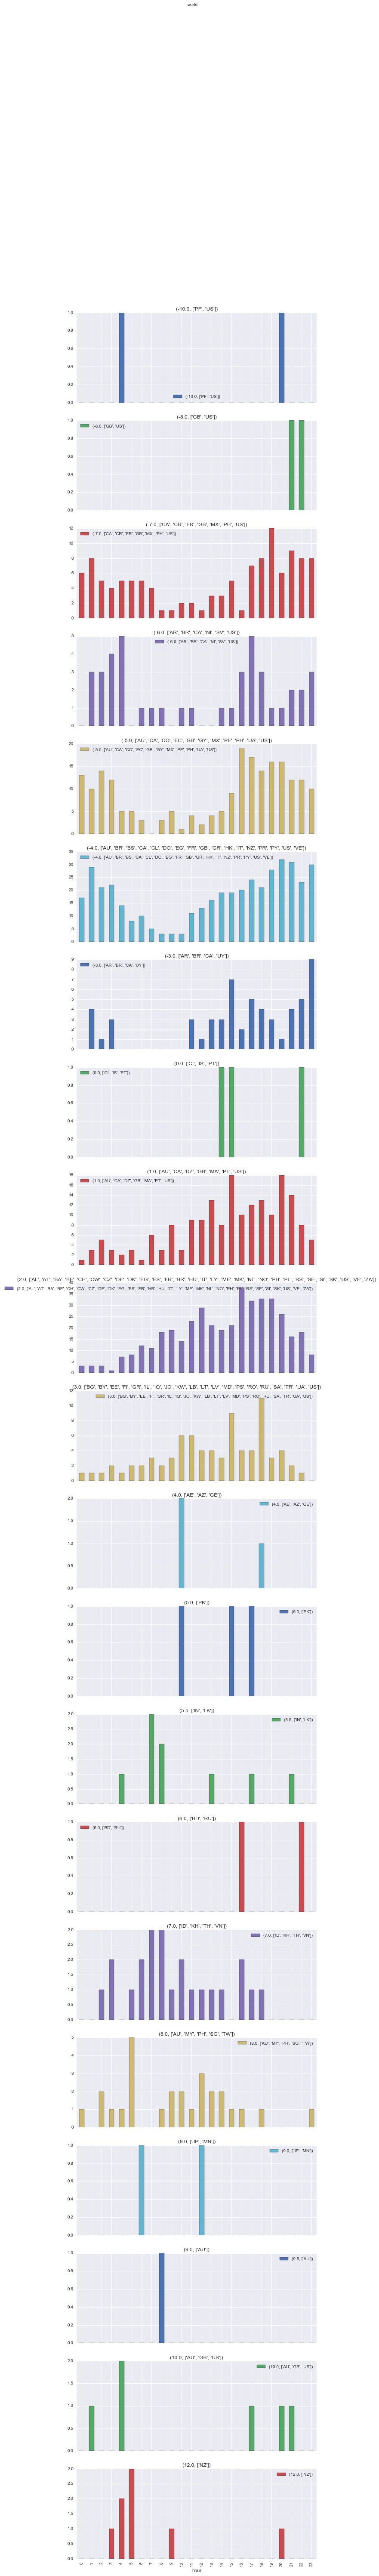

In [23]:
#графики максимального количества игроков в каждом часовом поясе (time zone)
table.plot(kind = "bar", title="world", subplots=True, figsize=(10,125), layout=(28,1))